# Applied Capstone Project - The Battle of Neighborhoods in Toronto, Canada

# Introduction
Toronto is Canada's largest city and a world leader in such areas as business, finance, technology, entertainment and culture. Its large population of immigrants from all over the globe has also made Toronto one of the most multicultural cities in the world.
Toronto has the largest Indo-Canadian population in Canada comprising of 10.4% (approx. 0.6 million people) Almost 51% of the entire Indo-Canadian community resides in the Greater Toronto Area. Most Indo-Canadians in the Toronto area live in Brampton, Markham, Scarborough, Etobicoke, and Mississauga. The Indo-Canadians in this region are mostly of Punjabi, Telugu, Tamil, Gujarati, Marathi, Malayalee and Goan origin. Canadian carrier Air Canada operates flights from Toronto Pearson International Airport back to India.
Also, students of Indian origin make up over 35% of Ryerson University, 30% of York University, and 20% of the University of Toronto's student bodies, respectively.
With its diverse culture, comes diverse food items. There are many restaurants in Toronto, each belonging to different categories like Indian, Chinese, French etc.
So as part of this project, we will list and visualize all major parts of Toronto that has great Indian Restaurants.

# Data
For this project we need the following data:
Toronto data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
Data source: click here 
Description: This webpage contains the required information. And we will scrape this data set to explore various neighborhoods of Toronto.
Indian Restaurants in each neighborhood of Toronto
Data source: Foursquare API
Description: By using this API we will get all the venues in each neighborhood. We can filter these venues to get only Indian Restaurants.
We can then get the likes, ratings etc., to rank the restaurants.
GeoSpace data
Data source: click here 
By using this data we draw boundaries and visualize venues on map.


# Approach
View the Toronto's city data from: URL 
Using Web Scrapping technique, collect required data.
Using Foursquare API, we will find all venues for each neighborhood.
Filter out all venues that are Indian Restaurants.
Find rating, tips and like count for each Indian Restaurants using Foursquare API.
Using rating for each restaurant, we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)

Questions that can be asked using the above-mentioned datasets


What is best location in Toronto for Indian Cuisine?
Which areas have potential Indian Restaurant Market?
Which all areas lack Indian Restaurants?
Which is the best place to stay if I prefer Indian Cuisine?

ANALYSIS

In [5]:
from bs4 import BeautifulSoup as bs # for webscrapping
import requests # for handling request to websites
import pandas as pd # for data analysis and manipulation
import numpy as np #for mathematical computing
import matplotlib.pyplot as plt # for plotting
import seaborn as sns# for plotting
import folium # map rendering library
from folium import plugins # to group nearby locations
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Loading web page

In [6]:
page = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = bs(page,'html.parser')

Viewing the required data from webpage,extracting data and making a dataframe

In [7]:
table_post=soup.find('table')

In [8]:
fields = table_post.find_all('td') # All required values are at 'td'

postcode = [] #Empty list to be appended
borough = [] #Empty list to be appended
neighbourhood = [] #Empty list to be appended

for i in range(0, len(fields),3): # Range Intitalizing from 0 to len(fields) which is no of 'td'=540, and step size of 3, since there are 3 columns 
    postcode.append(fields[i].text.strip()) # field 0, it is post code
    borough.append(fields[i+1].text.strip()) # filed 1, it is borough
    neighbourhood.append(fields[i+2].text.strip()) # field 2, it is neighborhood
        
df = pd.DataFrame(data=[postcode, borough, neighbourhood]).transpose()# since all are list, we have to transform it to columns
df.columns = ['Postcode', 'Borough', 'Neighborhood']
df.head()

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Dataframe without Borough as not assigned

In [11]:
df_reqd_1 = df[df['Borough'] != 'Not assigned'].reset_index(drop=True)
df_reqd_1.head()

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Loading geospatial data and merging it into a single data frame

In [12]:
geo_url = 'https://cocl.us/Geospatial_data' 
df_geo = pd.read_csv(geo_url)
df_geo.rename(columns={'Postal Code':'Postcode'}, inplace=True) #Renaming 'Postal Code' from GeoSpatial df to 'Postcode', same as df_reqd_1
df_geo.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
df_reqd_2 = pd.merge(df_reqd_1,df_geo,on='Postcode')
print(df_reqd_2.isnull().sum())
df_reqd_2.head()

Postcode        0
Borough         0
Neighborhood    0
Latitude        0
Longitude       0
dtype: int64


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Defining a function to get the latitude and longitude values

In [14]:
def geo_location(address):
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude
    print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))

Visualizing the map

In [19]:
map_toronto = folium.Map(location=geo_location('Toronto'), zoom_start=10,tiles='https://api.mapbox.com/styles/v1/explorer020/cka9yy2dn14l51iptugr1shzf/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiZXhwbG9yZXIwMjAiLCJhIjoiY2thOXhvYjdyMHJoYzJycDRlbmw3YTg3ZiJ9.T9QjJc87oYLSknnlBH21Tg',attr='XXX Mapbox Attribution') # calling the geo_location function by passing address as Toronto.

# add markers to map
for lat, lng, borough, neighborhood in zip(df_reqd_2['Latitude'], df_reqd_2['Longitude'], df_reqd_2['Borough'], df_reqd_2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='orange',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


Here we can see that there is 1 place which belongs to Mississauga but it is wrongly mentioned under the Toronto City.
We will remove it and plot it again.

In [18]:
df_reqd_2=df_reqd_2[~df_reqd_2["Borough"].isin(['Mississauga'])] #dropping Mississauga
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=geo_location('Toronto'), zoom_start=11,tiles='https://api.mapbox.com/styles/v1/explorer020/cka9yy2dn14l51iptugr1shzf/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiZXhwbG9yZXIwMjAiLCJhIjoiY2thOXhvYjdyMHJoYzJycDRlbmw3YTg3ZiJ9.T9QjJc87oYLSknnlBH21Tg',attr='XXX Mapbox Attribution')

# add markers to map
for lat, lng, borough, neighborhood in zip(df_reqd_2['Latitude'], df_reqd_2['Longitude'], df_reqd_2['Borough'], df_reqd_2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='Green',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    

map_toronto.save('map_1.html')
map_toronto

Loading foursquare API

In [20]:
CLIENT_ID='ITW1NY0MRQ5OBN3XE1CW10OZZOYG2YE10244WWQVPFZ1AHHC'
CLIENT_SECRET='5ESDAEHJEPDCCAQEPOXHPACLIRXN3WEKFRLDZOLW14QKDUK5'
VERSION='20200622'

Now, let's get the top 100 venues that are in within a radius of 3000 meters.

Defining a Function to get list of neighborhood


In [21]:
def get_venues(lat,lng):
    
    #set variables
    radius=3000
    LIMIT=100
     
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    #results = json_normalize(results)
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df1 = pd.DataFrame(venue_details,columns=column_names)
    return df1


Defining a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [22]:
def get_venue_details(venue_id):
    
   #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
           venue_id,
           CLIENT_ID, 
           CLIENT_SECRET, 
           VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df2 = pd.DataFrame(venue_details,columns=column_names)
    return df2

Visualizing No. of Neighborhood in each Borough

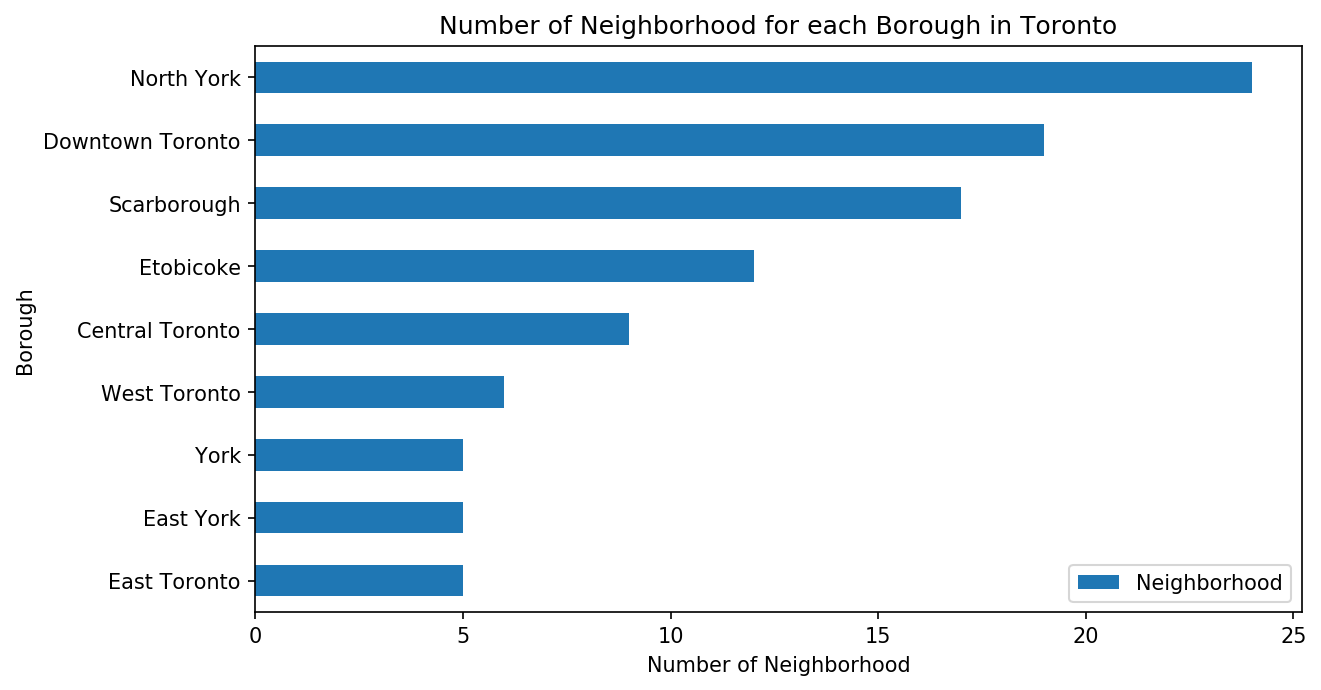

In [23]:
plt.figure(figsize=(9,5), dpi=150)
# title
plt.title('Number of Neighborhood for each Borough in Toronto')
#On x-axis
plt.xlabel('Number of Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('Borough', fontsize=10)
#giving a bar plot
df_reqd_2.groupby('Borough')['Neighborhood'].count().sort_values().plot(kind='barh')
#legend
plt.legend()
#displays the plot
plt.show()

Let us find out number of Indian Restaurants in Each Neighborhood.


In [25]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_toronto=pd.DataFrame(columns=column_names)
count=1
for row in df_reqd_2.values.tolist():
    Postcode, Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(df_reqd_2),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_toronto = indian_rest_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 102 ) Indian Resturants in Parkwoods, North York:1
( 2 / 102 ) Indian Resturants in Victoria Village, North York:2
( 3 / 102 ) Indian Resturants in Regent Park, Harbourfront, Downtown Toronto:0
( 4 / 102 ) Indian Resturants in Lawrence Manor, Lawrence Heights, North York:0
( 5 / 102 ) Indian Resturants in Queen's Park, Ontario Provincial Government, Downtown Toronto:0
( 6 / 102 ) Indian Resturants in Islington Avenue, Humber Valley Village, Etobicoke:1
( 7 / 102 ) Indian Resturants in Malvern, Rouge, Scarborough:0
( 8 / 102 ) Indian Resturants in Don Mills, North York:0
( 9 / 102 ) Indian Resturants in Parkview Hill, Woodbine Gardens, East York:2
( 10 / 102 ) Indian Resturants in Garden District, Ryerson, Downtown Toronto:0
( 11 / 102 ) Indian Resturants in Glencairn, North York:0
( 12 / 102 ) Indian Resturants in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale, Etobicoke:0
( 13 / 102 ) Indian Resturants in Rouge Hill, Port Union, Highland Creek, Scarboroug

How many Indian Restaurants did we get?
Are there any null values?

In [26]:
print(indian_rest_toronto.shape)
print(indian_rest_toronto.isnull().sum())
indian_rest_toronto.head()

(116, 4)
Borough         0
Neighborhood    0
ID              0
Name            0
dtype: int64


,Borough,Neighborhood,ID,Name
0,North York,Parkwoods,4c27cddd9fb5d13a8cab9857,Patna Kebab House
1,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas
2,North York,Victoria Village,4c27cddd9fb5d13a8cab9857,Patna Kebab House
3,Etobicoke,"Islington Avenue, Humber Valley Village",4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine
4,East York,"Parkview Hill, Woodbine Gardens",4b9bccbef964a520ae2636e3,Sultan Of Samosas



Let us look Indian Restaurants in each Borough


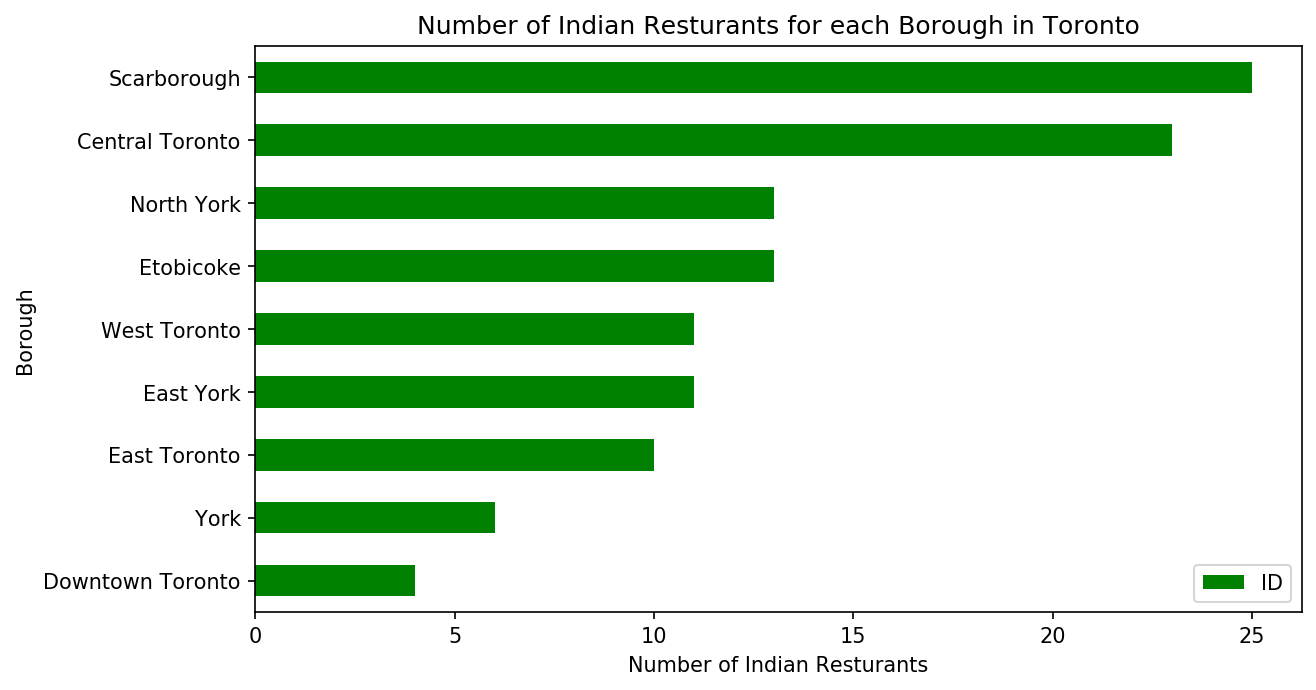

In [27]:
plt.figure(figsize=(9,5), dpi = 150)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto')
#On x-axis
plt.xlabel('Number of Indian Resturants', fontsize = 10)
#On y-axis
plt.ylabel('Borough', fontsize=10)
#giving a bar plot
indian_rest_toronto.groupby('Borough')['ID'].count().sort_values().plot(kind='barh',color='Green')
#legend
plt.legend()
#displays the plot
plt.show()

Scarborough and Central Toronto has the maximum number of Indian Restaurants, while Downtown has the least.

Which Neighborhood has the highest number of Indian Restaurants?

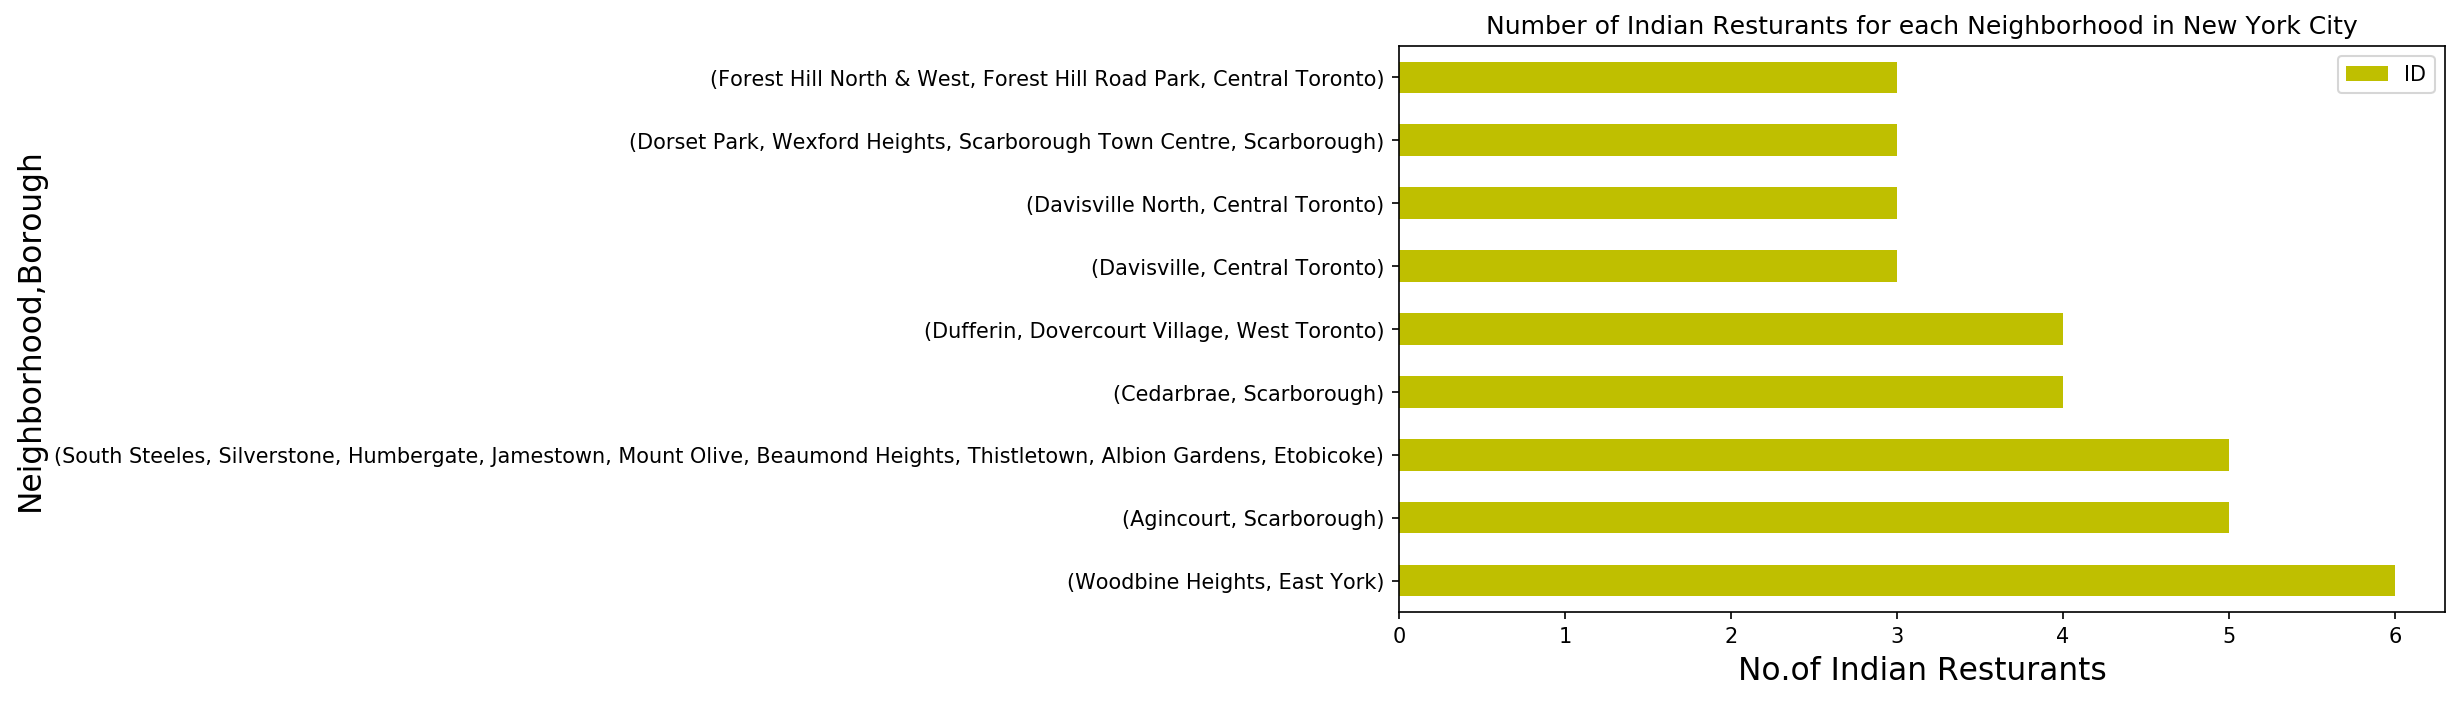

In [28]:
plt.figure(figsize=(9,5), dpi = 150)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('No.of Indian Resturants', fontsize = 15)
#On y-axis
plt.ylabel('Neighborhood', fontsize=15)
#giving a bar plot
#indian_rest_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='barh', color='y')
indian_rest_toronto.groupby(['Neighborhood','Borough'])['ID'].count().nlargest(9).plot(kind='barh', color='y')


#legend
plt.legend()
#displays the plot
plt.show()

We can see that Woodbine, East York has the highest number of Indian Restaurants than any other Borough of Toronto.

Now let us get the Ranking of Each Restaurant based on Likes, Ratings, Tips from the FourSquare API.

In [29]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_toronto=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_toronto.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_toronto),')','processed')
    indian_rest_stats_toronto = indian_rest_stats_toronto.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  4c27cddd9fb5d13a8cab9857  Patna Kebab House      4     8.0     6
( 1 / 116 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b9bccbef964a520ae2636e3  Sultan Of Samosas     29     8.6    24
( 2 / 116 ) processed
                         ID               Name  Likes  Rating  Tips
0  4c27cddd9fb5d13a8cab9857  Patna Kebab House      4     8.0     6
( 3 / 116 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4af1c64ff964a5200ae321e3  Chutneys Fine Indian Cuisine      5     6.9    10
( 4 / 116 ) processed
                         ID               Name  Likes  Rating  Tips
0  4b9bccbef964a520ae2636e3  Sultan Of Samosas     29     8.6    24
( 5 / 116 ) processed
                         ID              Name  Likes  Rating  Tips
0  507a19e5e4b0602b62f73d11  Faley Restaurant      6     6.7     4
( 6 / 116 ) processed
                         ID     

KeyError: 'venue'

We got the rankings and ratings

In [30]:
print('DataFrame has :',indian_rest_stats_toronto.shape[0],'rows and', indian_rest_stats_toronto.shape[1],'columns')
indian_rest_stats_toronto.head()

DataFrame has : 50 rows and 7 columns


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,North York,Parkwoods,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
1,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas,29,8.6,24
2,North York,Victoria Village,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
3,Etobicoke,"Islington Avenue, Humber Valley Village",4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine,5,6.9,10
4,East York,"Parkview Hill, Woodbine Gardens",4b9bccbef964a520ae2636e3,Sultan Of Samosas,29,8.6,24


As we are using FourSquare API to fetch the details of each Indian Restaurants, it comes under Premium Call and has a Limit of 500 Calls/Day.
So, let us save the DataFrame to a CSV File, and from here on we will use the CSV file for further manipulations.¶ 

In [31]:
indian_rest_stats_toronto.to_csv('indian_rest_stats_toronto.csv', index=False)
print('File Saved in your directory as indian_rest_stats_toronto.csv')

File Saved in your directory as indian_rest_stats_toronto.csv


Loading the file

In [32]:
indian_rest_stats_toronto_csv=pd.read_csv('indian_rest_stats_toronto.csv')
indian_rest_stats_toronto_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,North York,Parkwoods,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
1,North York,Victoria Village,4b9bccbef964a520ae2636e3,Sultan Of Samosas,29,8.6,24
2,North York,Victoria Village,4c27cddd9fb5d13a8cab9857,Patna Kebab House,4,8.0,6
3,Etobicoke,"Islington Avenue, Humber Valley Village",4af1c64ff964a5200ae321e3,Chutneys Fine Indian Cuisine,5,6.9,10
4,East York,"Parkview Hill, Woodbine Gardens",4b9bccbef964a520ae2636e3,Sultan Of Samosas,29,8.6,24


Indian Restaurants based on MAX Likes.

In [33]:
print(indian_rest_stats_toronto_csv.iloc[indian_rest_stats_toronto_csv['Likes'].idxmax()])

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.7
Tips                                  75
Name: 26, dtype: object


Indian restaurants based on highest ratings

In [34]:
print(indian_rest_stats_toronto_csv.iloc[indian_rest_stats_toronto_csv['Rating'].idxmax()])

Borough                             York
Neighborhood          Humewood-Cedarvale
ID              52418b0b7e48222eea81d2d2
Name                    Pukka Restaurant
Likes                                 41
Rating                                 9
Tips                                  26
Name: 14, dtype: object


Indian restaurants based on max tips

In [35]:
print(indian_rest_stats_toronto_csv.iloc[indian_rest_stats_toronto_csv['Tips'].idxmax()])

Borough                 Downtown Toronto
Neighborhood                    Christie
ID              4adb969ef964a520332921e3
Name              Banjara Indian Cuisine
Likes                                142
Rating                               8.7
Tips                                  75
Name: 26, dtype: object


Top Borough for Indian Restaurants based on Average Ratings.

In [36]:
toronto_borough_stats=indian_rest_stats_toronto_csv.groupby('Borough')['Rating'].mean().reset_index()
toronto_borough_stats.columns=['Borough','Average Rating']
toronto_borough_stats.nlargest(10,'Average Rating')

,Borough,Average Rating
0,Downtown Toronto,8.850000
7,York,8.750000
6,West Toronto,8.466667
1,East Toronto,8.200000
2,East York,7.927273
4,North York,7.475000
3,Etobicoke,6.950000
5,Scarborough,6.900000


Visualizing the best of borough

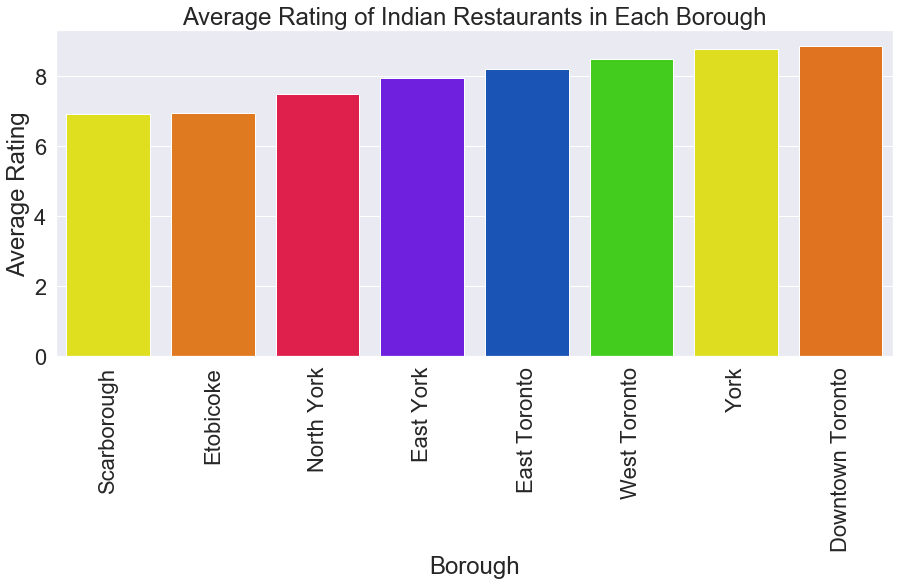

In [38]:
toronto_borough_stats=toronto_borough_stats.sort_values(by='Average Rating')
sns.set(style="darkgrid",font_scale=2,rc={'figure.figsize':(15,6)})
ax = sns.barplot(x="Borough", y="Average Rating", data=toronto_borough_stats, palette="prism_r")
plt.title('Average Rating of Indian Restaurants in Each Borough')
plt.xticks(rotation=90)
plt.show()

Top Neighborhoods for Indian Restaurants based on Average Ratings.

In [39]:
toronto_neighborhood_stats=indian_rest_stats_toronto_csv.groupby(['Neighborhood'])['Rating'].mean().reset_index()
toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']
toronto_neighborhood_stats.sort_values(by='Average Rating',ascending=False).head()

,Neighborhood,Average Rating
11,Humewood-Cedarvale,8.85
4,Christie,8.85
20,"The Danforth West, Riverdale",8.70
15,"Little Portugal, Trinity",8.70
2,Caledonia-Fairbanks,8.65


visualizing the best of neighborhoods

Based on ratings above 8.0

In [40]:
avg_rating=8.0
best_toronto_neighborhood_stats=toronto_neighborhood_stats[toronto_neighborhood_stats['Average Rating']>=avg_rating]
print(best_toronto_neighborhood_stats.shape[0],'Indian Restaurants has average rating of', avg_rating, 'and above. \n Check the list below.')
best_toronto_neighborhood_stats.sort_values(by='Average Rating',ascending=False)

13 Indian Restaurants has average rating of 8.0 and above. 
 Check the list below.


,Neighborhood,Average Rating
4,Christie,8.850
11,Humewood-Cedarvale,8.850
15,"Little Portugal, Trinity",8.700
20,"The Danforth West, Riverdale",8.700
2,Caledonia-Fairbanks,8.650
9,"Golden Mile, Clairlea, Oakridge",8.600
6,"Dufferin, Dovercourt Village",8.525
7,"East Toronto, Broadview North (Old East York)",8.400
12,"India Bazaar, The Beaches West",8.400
21,Victoria Village,8.300


Merging dataframes to get the coordinates

In [41]:
best_neighborhood_folium=pd.merge(best_toronto_neighborhood_stats,df_reqd_2,how='inner',on='Neighborhood')
best_neighborhood_folium=best_neighborhood_folium.rename(columns={'Borough_x':'Borough'})
best_neighborhood_folium=best_neighborhood_folium[['Borough','Neighborhood','Average Rating','Latitude','Longitude']]
print('We have our required DatFrame ready to be plotted on a Map.')
best_neighborhood_folium=best_neighborhood_folium.sort_values(by='Average Rating', ascending=False).reset_index(drop=True)
best_neighborhood_folium['Average Rating']=best_neighborhood_folium['Average Rating'].round(2)# set precision to 2 decimal place
best_neighborhood_folium

We have our required DatFrame ready to be plotted on a Map.


,Borough,Neighborhood,Average Rating,Latitude,Longitude
0,Downtown Toronto,Christie,8.85,43.669542,-79.422564
1,York,Humewood-Cedarvale,8.85,43.693781,-79.428191
2,West Toronto,"Little Portugal, Trinity",8.70,43.647927,-79.419750
3,East Toronto,"The Danforth West, Riverdale",8.70,43.679557,-79.352188
4,York,Caledonia-Fairbanks,8.65,43.689026,-79.453512
5,Scarborough,"Golden Mile, Clairlea, Oakridge",8.60,43.711112,-79.284577
6,West Toronto,"Dufferin, Dovercourt Village",8.52,43.669005,-79.442259
7,East York,"East Toronto, Broadview North (Old East York)",8.40,43.685347,-79.338106
8,East Toronto,"India Bazaar, The Beaches West",8.40,43.668999,-79.315572
9,North York,Victoria Village,8.30,43.725882,-79.315572


Visualizing The Best of Neighborhoods based on Average Rating of 8.0 and above on Map.

In [42]:
best_neighborhood_avg_rating_map_2 = folium.Map(location=geo_location('Toronto'), zoom_start=10, tiles='https://api.mapbox.com/styles/v1/explorer020/cka9yy2dn14l51iptugr1shzf/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiZXhwbG9yZXIwMjAiLCJhIjoiY2thOXhvYjdyMHJoYzJycDRlbmw3YTg3ZiJ9.T9QjJc87oYLSknnlBH21Tg',attr='XXX Mapbox Attribution')

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(best_neighborhood_avg_rating_map_2)

for lat, lng, rating, neighborhood in zip(best_neighborhood_folium['Latitude'], best_neighborhood_folium['Longitude'],best_neighborhood_folium['Average Rating'],best_neighborhood_folium['Neighborhood']):
    label = '{},{}'.format(rating,neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(incidents)  
best_neighborhood_avg_rating_map_2.save('best_neighborhood_avg_rating_map_2.html')
best_neighborhood_avg_rating_map_2

# CONCLUSION
What is best location in Toronto for Indian Cuisine?
Banjara Indian Cuisine, Dufferin, West Toronto has the best Indian food.

Which areas have potential Indian Restaurant Market?
North York, Etobicoke has the least rated Indian restaurants.
For an investor, it's an opportunity to grab to come up with high quality restaurant.

Which all areas lack Indian Restaurants?
Downtown has the lowest number of Indian Restaurants but are highly rated.
For an investor, to come up with variety and quality is a challenge to conquer.

Which is the best place to stay if I prefer Indian Cuisine?
West and Central Toronto are the places where one should stay if they prefer Indian Cuisine. These areas have quality and variety both.